In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [19]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [20]:
df.dropna(inplace=True)

pickup_dt = df.pickup_datetime.dt

df["hour"] = pickup_dt.hour
df["day"] = pickup_dt.day
df["weekday"] = pickup_dt.weekday
df["weekend"] = (df.weekday >= 5).astype(int)
df["month"] = pickup_dt.month
df["year"] = pickup_dt.year
df.drop(columns=["pickup_datetime"], inplace=True)

df["Distance"] =  np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"], inplace=True)

df.head()

,fare_amount,passenger_count,hour,day,weekday,weekend,month,year,Distance
0,4.5,1.0,17,15,0,0,6,2009,0.011742
1,16.9,1.0,16,5,1,0,1,2010,0.107481
2,5.7,2.0,0,18,3,0,8,2011,0.019212
3,7.7,1.0,4,21,5,1,4,2012,0.029386
4,5.3,1.0,7,9,1,0,3,2010,0.027194


In [21]:
X = df.drop(columns=["fare_amount"])
y = df["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 8), (3784, 8), (15134,), (3784,))

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax", poly=2, transform="yeo-johnson"), ['passenger_count', 'year', 'Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['weekday', 'weekend', 'day','month', 'hour']),
])

from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7201432840331174 0.7148593907185042 0.7453929042134977


In [25]:
rsp.enet_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [24]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax", poly=2, transform="yeo-johnson"), ['passenger_count', 'year', 'Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['weekday', 'weekend', 'day','month', 'hour']),
])

from sklearn.linear_model import ElasticNet
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.010818791379215648, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.7003578299727714, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7075760152307097 0.7049185763621525 0.7326934563953191


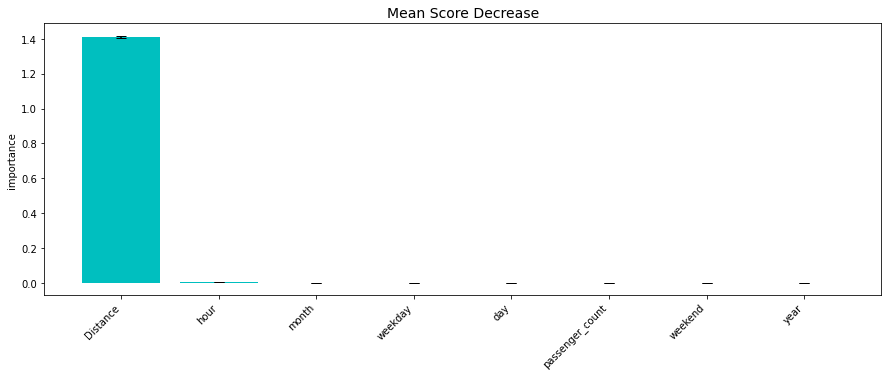

In [26]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


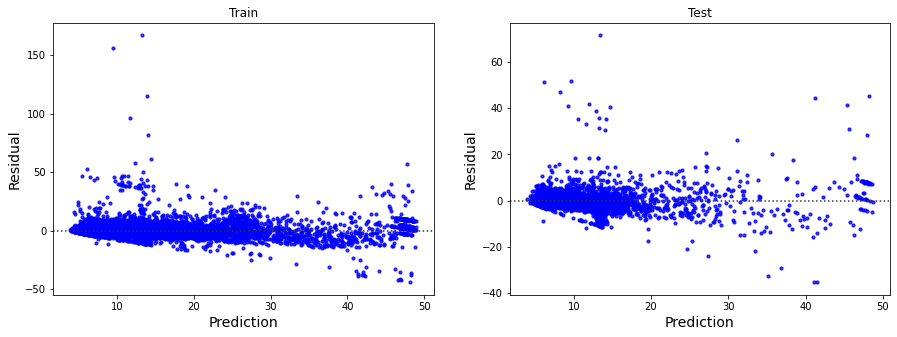

In [27]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
plot_residual(X_train, y_train, X_test, y_test, model)

### ngeliat data yg errornya gede

In [29]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis["fare"] = y_train
df_analysis["error"] = error

df_analysis.sort_values(by="error", ascending=False).head(10)

,passenger_count,hour,day,weekday,weekend,month,year,Distance,fare,error
1335,1.0,20,16,2,0,1,2013,0.000000,180.00,166.769511
1483,1.0,21,7,4,0,8,2009,0.000416,165.00,155.526513
6630,1.0,1,16,4,0,5,2014,0.000000,128.83,114.994538
14142,1.0,10,12,4,0,12,2014,0.045860,108.00,96.329238
12915,1.0,1,7,2,0,9,2011,0.000000,96.00,81.994214
10524,1.0,14,4,1,0,5,2010,0.000000,75.80,61.439751
1494,1.0,14,1,1,0,9,2009,0.000031,70.00,57.636551
12349,1.0,15,1,5,1,5,2010,0.434492,104.67,56.939035
2432,1.0,1,2,4,0,11,2012,0.003817,58.60,52.528199
2346,1.0,0,7,5,1,2,2009,0.000000,63.00,49.673987


20% snipet2 doang 
sisanya yaa effort